# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Описание целей и задач

Необходимо проверить предсказательную способность разных моделей, чтобы построить рекомендательную систему тарифов на основе данных клиентов (количества звонков, общей продолжительности звонков, количесва сообщений и использованных ГБ трафика). Лучшая модель и будет лежеть в основе такой системы

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/users_behavior.csv")
print(df.shape)
df.head(5)

(3214, 5)


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
len(df[df["is_ultra"]==1])/len(df)

0.30647168637212197

Количество пользователей, использующих тариф Ультра, в датасете - 30%. Неравномерность в данных может плохо сказаться на предсказательной способности моделей

## Разбейте данные на выборки

Изначально определимся с целевым признаком. В нашем случае это `is_ultra`

In [4]:
df_target = df["is_ultra"]
df_features = df.drop("is_ultra", axis=1)

Так как тестовая выборка изначально не дана, то разделим исходный датасет на три выборки - обучающую, валидационную и тестовую в пропорции 60-20-60

In [5]:
train_target, test_target, train_features, test_features = train_test_split(
    df_target, df_features, test_size=0.4, random_state=1)

In [6]:
valid_target, test_target, valid_features, test_features = train_test_split(
    test_target, test_features, test_size=0.5, random_state=1)

In [7]:
print("Размер обучающей выборки:", train_target.shape)
print("Размер валидационной выборки:", valid_target.shape)
print("Размер тестовой выборки:", test_target.shape)

Размер обучающей выборки: (1928,)
Размер валидационной выборки: (643,)
Размер тестовой выборки: (643,)


In [8]:
print(train_target.mean())
print(valid_target.mean())
print(test_target.mean())

0.2966804979253112
0.3359253499222395
0.30637636080870917


## Исследуйте модели

### Дерево решений

In [9]:
max = 0
for depth in range(1,5):
    model_tree = DecisionTreeClassifier(random_state=1, max_depth=depth) # Создаём модель
    model_tree.fit(train_features, train_target)                         # Обучаем на обучающей выборке
    result = model_tree.score(valid_features, valid_target)                   # Находим accuracy модели
    if result > max:
        max = result
        best_depth = depth
        best_model_tree = model_tree
    print(depth, result)
print("-"*20)
print("Лучший accuracy:", max)
print("При глубине дерева:", best_depth) 

1 0.71850699844479
2 0.7558320373250389
3 0.7713841368584758
4 0.7682737169517885
--------------------
Лучший accuracy: 0.7713841368584758
При глубине дерева: 3


### Случайный лес

In [10]:
max = 0
for max_f in ["sqrt", None]:
    print(max_f)
    for est in range(1,12):
        model_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_features = max_f)
        model_forest.fit(train_features, train_target)
        result = model_forest.score(valid_features, valid_target)
        if result > max:
            max = result
            best_estimators = est
            best_model_forest = model_forest
            best_max_f = max_f
        print(est, result)
print("-"*20)
print("Лучший accuracy:", max)
print("При количестве деревьев:", best_estimators, "и максимальном количестве признаков", best_max_f)

sqrt
1 0.7325038880248833
2 0.7542768273716952
3 0.7465007776049767
4 0.7713841368584758
5 0.7807153965785381
6 0.7776049766718507
7 0.7791601866251944
8 0.7776049766718507
9 0.7838258164852255
10 0.7807153965785381
11 0.7822706065318819
None
1 0.7293934681181959
2 0.7542768273716952
3 0.7527216174183515
4 0.7744945567651633
5 0.7698289269051322
6 0.7807153965785381
7 0.7807153965785381
8 0.776049766718507
9 0.7900466562986003
10 0.7900466562986003
11 0.7853810264385692
--------------------
Лучший accuracy: 0.7900466562986003
При количестве деревьев: 9 и максимальном количестве признаков None


### Логистическая регрессия

In [11]:
model_regression = LogisticRegression(random_state=1, solver='lbfgs', max_iter=1000)
model_regression.fit(train_features, train_target)
model_regression.score(valid_features, valid_target)

0.7200622083981337

На валидационной выборке лучшие результаты показали модели решающего дерева и случайного леса, логистическая регрессия показала самый худший результат. Особенности построения модели на наших данных - неравномерность деления целевого параметра (70 на 30) и малое количесво параметров (4 штуки). Эти особенности неизбежно будут влиять на точность предсказания

## Проверьте модель на тестовой выборке

### Проверка на очевидность

Лучший результат на валидационной выборке показала модель случайного леса, поэтому примем именно её

In [12]:
model = best_model_forest

In [13]:
print("Accuracy модели случайного леса на тестовой выборке:", model.score(test_features, test_target))

Accuracy модели случайного леса на тестовой выборке: 0.7776049766718507


## (бонус) Проверьте модели на адекватность

Из прерыдущих уроков ивестно: 
- в тариф "Смарт" включены 500 минут разговора, 50 сообщений и 15 ГБ трафика
- в тариф "Ультра" включены 3000 минут разговора, 1000 сообщений, 30 ГБ трафика и более мягкие цены за превышение этих лимитов по сравнению со "Смартом"
Сконструируем двух клиентов так, чтобы один не превышал лимитов "Смарта", а другой немного превышал "Ультру"

In [14]:
check = pd.DataFrame(
[[10, 400, 40, 13000],        # Клиент, которому не нужен "Ультра"
 [100, 3100, 1100, 35000]],   # Клиент, который не может без "Ультра"
 columns=df_features.columns)

print(model.predict(check))

[0 1]


Всё сходится со здравым смыслом - "Ультра" будет полезна только второму клиенту

### Сравнение с Dummy моделью

In [15]:
dummy_model = DummyClassifier()
dummy_model.fit(train_features, train_target)
dummy_model.score(valid_features, valid_target)

0.6640746500777605

Эту проверку наша модель тоже прошла, показала результат лучше, чем простейшая

### Сonfusion_matrix

Посмотрим, в какую сторону модель ошибалась больше

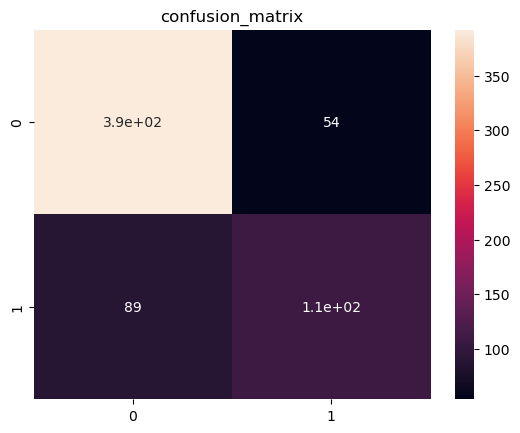

In [16]:
y_true = test_target
y_pred = model.predict(test_features)
sb.heatmap(confusion_matrix(y_true, y_pred), annot=True)

plt.title( "confusion_matrix" )
plt.show()

Из этой матрицы видно, что ложноотрицательных (должно быть 1, а предсказала 0) больше, чем ложноположительных (должно быть 0, а пресказала 1), то есть модель скорее пропустит нужного клиента, чем предложит тариф "Ультра" человеку, которому он не нужен)

## Общий вывод

В исходном датасете наблюдается дисбаланс в целевом параметре (70 на 30), это влияет на точность предсказаний. 

Были рассмотрены три типа моделей - решающее дерево, случайный лес и логистическая регрессия. При проверке на валидационной выборке была определена лучшая модель - случайный лес с числом деревьев 9 показал accuracy 79%. При проверке на тестовой выборке модель показала accuracy 78%. 

Также была проведена проверка полученной модели - сравнений с dummy моделью и получение очевидных ожидаемых результатов. Обе проверки модель прошла успешно